# Practical 3: Introduction to Constraint Satisfaction

The aim of this lab is to provide an overview of the main concepts of constraint satisfaction problems through a worked example

**Problem:** A pandemic is rising. Hospitals must organize quickly to treat ill people.
We need to design algorithm which matches infected people and hospitals together given multiple criteria such as the severity of illness, patient age and location, hospital capacity and equipment, etc.

**Questions:** What other AI methods could be used to solve this problem? What are the advantages of using Constraint Satisfaction to solve it? 

<hr style="border:1px solid black"> </hr>

### OR-Tools

We will use the __[OR-Tools](https://developers.google.com/optimization)__ to solve our optimisation problem

Remember to install the OR-Tools module *before* starting the tutorial:  

In [1]:
pip install ortools

     |████████████████████████████████| 15.5 MB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 4.3 MB/s eta 0:00:01
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

     |████████████████████████████████| 11.3 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 930 kB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 12.2 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
Note: you may need to restart the kernel to use updated packages.


Import all toolboxes need to support the tutorial

In [1]:
from ortools.sat.python import cp_model # CP-SAT solver

import numpy as np
from random import randint
from math import ceil
import matplotlib.pyplot as plt # Data visualization

<hr style="border:1px solid black"> </hr>

### Declare key parameters
Our problem space has 4 key parameters. 

**Question** Can you identity them from the code below? 

In [3]:
# Number of hospitals
n_hospitals = 3
# Number of infected people
n_patients = 100
# Number of beds in every hospital
n_beds_in_hospitals = [10,20, 30]
# Location of infected people -- random integer tuple (x,y)
patients_loc = [(randint(0, 100), randint(0, 100)) for _ in range(n_patients)]
# Location of hospitals -- random integer tuple (x,y)
hospitals_loc = [(randint(0, 100), randint(0, 100)) for _ in range(n_hospitals)]  
# Illness severity -- 1 = mild -> 5 = severe
patients_severity = [randint(1, 5) for _ in range(n_patients)]

**Question** Will every patient get a bed? 

<hr style="border:1px solid black"> </hr>

### Visualise the problem space 

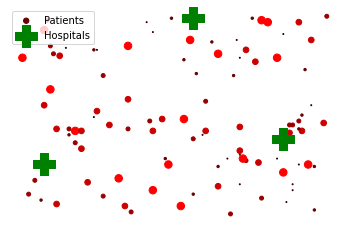

In [4]:
# Visualization
plt.rcParams["figure.figsize"] = (15,10)
shade_severity = [int(sev*255/5) for sev in patients_severity]
color_severity = ["#%02x0000" % (sev) for sev in shade_severity]
size_severity = [k**2.5 for k in patients_severity]
plt.scatter(*zip(*patients_loc), s=size_severity, c=color_severity, label="Patients")
plt.scatter(*zip(*hospitals_loc), s=500, c="g", marker="P", label="Hospitals")
plt.legend()
plt.axis('off')
plt.show()   

<hr style="border:1px solid black"> </hr>

### Declare constraint variables

Constraint satisfaction problem consists of a set of variables that must be assigned values in such a way that a set of constraints is satisfied.
- i represents a single hospital from our group of hospitals
- j a bed single bed in hospital i
- k represents a single patient from our group of patients 

We implement model the relationship betwen these variables as an `if-then` statement. 
    
*If* in the hospital `i`, the bed `j` is taken by the person `k` *then* `x[i,j,k] = 1`. 

We add those variables and their relationship to our model:

In [5]:
model = cp_model.CpModel()
x = {}
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      x[(i,j,k)] = model.NewBoolVar("x(%d,%d,%d)" % (i,j,k))

<hr style="border:1px solid black"> </hr>

### Goal of our problem: 
    
In order to associate each bed of an hospital to an ill person, we must find a set of variables (*n* unique combinations of `x[i,j,k] = 1`) that satisfies all of our constraints. 

**Question:** what is the maximum value of *n*? Why?

<hr style="border:1px solid black"> </hr>

### Hard constraints
Hard constraints define a goal for our model. They are essential, if they are not resolved then the problem can’t be tackled:

**Hard constraint 1:** There must be at most a single person in every bed

In [6]:
# Each bed must host at most one person
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    model.Add(sum(x[(i,j,k)] for k in range(n_patients)) <= 1)

**Hard constraint 2:** There must be at most a single bed assigned to every person.

In [7]:
# Each person must be placed in at most one bed
for k in range(n_patients):
  inner_sum = []
  for i in range(n_hospitals):
    inner_sum.append(sum(x[(i,j,k)] for j in range(n_beds_in_hospitals[i]))) 
  model.Add(sum(inner_sum) <= 1)

**Question:** What is the difference between these contraints?


<hr style="border:1px solid black"> </hr>

### Soft constraints
Next, there are soft constraints. Those are highly desired: our solution must try to satisfy them as much as possible, yet they are not essential to find a solution:
- Every sick person should be placed into a bed,
- Every person should be handled by the nearest hospital,
- Sick persons in severe condition should be handled first when there are not enough beds.

In [8]:
# Integer distance function
idist = lambda xy1, xy2: int(((xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2)**0.5)

# Gain factors (1/penalty factors)
gain_max_patients = 140
gain_severity = int(140/5)
gain_distance = 0

# Maximization objective
soft_csts = []
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      factor = \
        gain_max_patients \
        + gain_distance * idist(hospitals_loc[i], patients_loc[k]) \
        + gain_severity * patients_severity[k]
      soft_csts.append(factor * x[(i,j,k)])

model.Maximize(sum(soft_csts))

**Question:** What is the difference between how the hard constraints and soft constraints are expressed in our model? 

<hr style="border:1px solid black"> </hr>

### Run Solver
Now we can launch the solver. As the optimal solution may take time to find, this code is set up to find the optimal solution within a specified time limit. If it can’t manage to find the optimal solution, it will return the closest sub-optimal solution.

In [9]:
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 120.0
status = solver.Solve(model)

### Print out patient assignments

In [10]:
plot_lines = [[] for _ in range(n_hospitals)]
for i in range(n_hospitals):
  print("Hospital ", i)
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      if solver.Value(x[(i,j,k)]) == 1:
        print("\tPatient ", k, "in bed ", j)
        line_abs = [ hospitals_loc[i][0], patients_loc[k][0] ]
        line_ord = [ hospitals_loc[i][1], patients_loc[k][1] ]
        plot_lines[i].append([line_abs, line_ord])
print()
print("Inference time: %f s" % solver.WallTime())

Hospital  0
	Patient  2 in bed  0
	Patient  49 in bed  1
	Patient  15 in bed  2
	Patient  10 in bed  3
	Patient  37 in bed  4
	Patient  18 in bed  5
	Patient  46 in bed  6
	Patient  4 in bed  7
	Patient  68 in bed  8
	Patient  16 in bed  9
Hospital  1
	Patient  26 in bed  0
	Patient  6 in bed  1
	Patient  17 in bed  2
	Patient  23 in bed  3
	Patient  43 in bed  4
	Patient  60 in bed  5
	Patient  5 in bed  6
	Patient  28 in bed  7
	Patient  11 in bed  8
	Patient  69 in bed  9
	Patient  22 in bed  10
	Patient  59 in bed  11
	Patient  30 in bed  12
	Patient  61 in bed  13
	Patient  20 in bed  14
	Patient  98 in bed  15
	Patient  51 in bed  16
	Patient  7 in bed  17
	Patient  63 in bed  18
	Patient  95 in bed  19
Hospital  2
	Patient  73 in bed  0
	Patient  29 in bed  1
	Patient  67 in bed  2
	Patient  31 in bed  3
	Patient  44 in bed  4
	Patient  78 in bed  5
	Patient  38 in bed  6
	Patient  39 in bed  7
	Patient  8 in bed  8
	Patient  9 in bed  9
	Patient  75 in bed  10
	Patient  62 in b

### Visualise Results

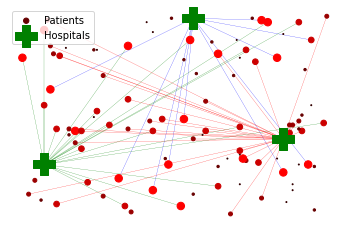

In [11]:
from itertools import cycle

shade_severity = [int(sev*255/5) for sev in patients_severity]
color_severity = ["#%02x0000" % (sev) for sev in shade_severity]
size_severity = [k**2.5 for k in patients_severity]
plt.scatter(*zip(*patients_loc), s=size_severity, c=color_severity, label="Patients", zorder=2)
plt.scatter(*zip(*hospitals_loc), s=500, c="g", marker="P", label="Hospitals", zorder=3)
colors = cycle('bgrcmk')
for i in range(n_hospitals):
  c = next(colors)
  for (x_,y_) in plot_lines[i]:
    plt.plot(x_,y_,c=c,linewidth=0.2, zorder=1)
plt.legend()
plt.axis('off')
plt.show()      

<hr style="border:1px solid black"> </hr>

## Exercise

Change the core parameters of the algoirthm and run for at least 6 different simulations. Compare the outputs

Example scenarios could include
- Increase population
- Different number of hospitals, varying capacity among hostipals
- Varying the hard and soft constrains
- Combinations thereof....

<hr style="border:1px solid black"> </hr>

In [27]:

n_hospitals = 4
# Number of infected people
n_patients = 500
# Number of beds in every hospital
n_beds_in_hospitals = [100, 250, 150, 100]
# Location of infected people -- random integer tuple (x,y)
patients_loc = [(randint(0, 100), randint(0, 100)) for _ in range(n_patients)]
# Location of hospitals -- random integer tuple (x,y)
hospitals_loc = [(randint(0, 100), randint(0, 100)) for _ in range(n_hospitals)]  
# Illness severity -- 1 = mild -> 5 = severe
patients_severity = [randint(1, 5) for _ in range(n_patients)]

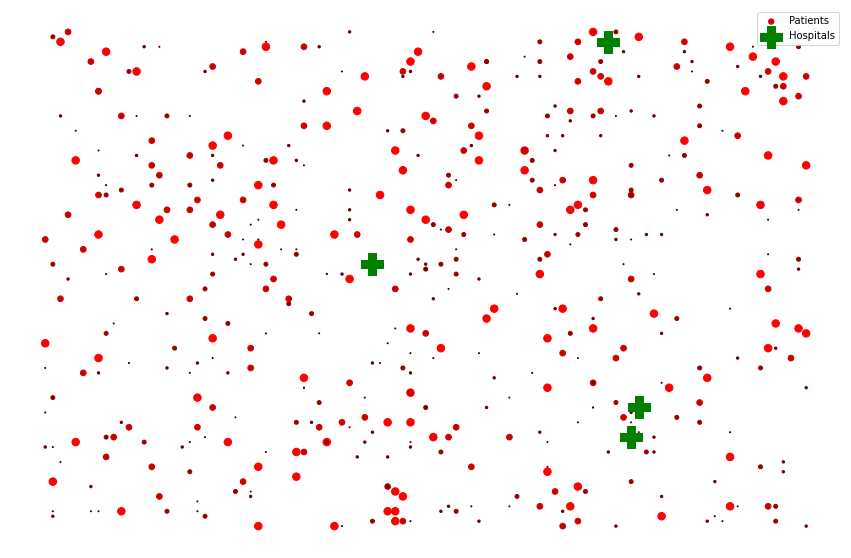

In [28]:
# Visualization
plt.rcParams["figure.figsize"] = (15,10)
shade_severity = [int(sev*255/5) for sev in patients_severity]
color_severity = ["#%02x0000" % (sev) for sev in shade_severity]
size_severity = [k**2.5 for k in patients_severity]
plt.scatter(*zip(*patients_loc), s=size_severity, c=color_severity, label="Patients")
plt.scatter(*zip(*hospitals_loc), s=500, c="g", marker="P", label="Hospitals")
plt.legend()
plt.axis('off')
plt.show()   

In [29]:
model = cp_model.CpModel()
x = {}
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      x[(i,j,k)] = model.NewBoolVar("x(%d,%d,%d)" % (i,j,k))

In [30]:
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    model.Add(sum(x[(i,j,k)] for k in range(n_patients)) <= 1)

In [31]:
for k in range(n_patients):
  inner_sum = []
  for i in range(n_hospitals):
    inner_sum.append(sum(x[(i,j,k)] for j in range(n_beds_in_hospitals[i]))) 
  model.Add(sum(inner_sum) <= 1)

In [32]:
# Integer distance function
idist = lambda xy1, xy2: int(((xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2)**0.5)

# Gain factors (1/penalty factors)
gain_max_patients = 10
gain_severity = 100
gain_distance = 0

# Maximization objective
soft_csts = []
for i in range(n_hospitals):
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      factor = \
        gain_max_patients \
        + gain_distance * idist(hospitals_loc[i], patients_loc[k]) \
        + gain_severity * patients_severity[k]
      soft_csts.append(factor * x[(i,j,k)])

model.Maximize(sum(soft_csts))

In [33]:
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 120.0
status = solver.Solve(model)

In [34]:
plot_lines = [[] for _ in range(n_hospitals)]
for i in range(n_hospitals):
  print("Hospital ", i)
  for j in range(n_beds_in_hospitals[i]):
    for k in range(n_patients):
      if solver.Value(x[(i,j,k)]) == 1:
        print("\tPatient ", k, "in bed ", j)
        line_abs = [ hospitals_loc[i][0], patients_loc[k][0] ]
        line_ord = [ hospitals_loc[i][1], patients_loc[k][1] ]
        plot_lines[i].append([line_abs, line_ord])
print()
print("Inference time: %f s" % solver.WallTime())

Hospital  0


IndexError: list index (0) out of range

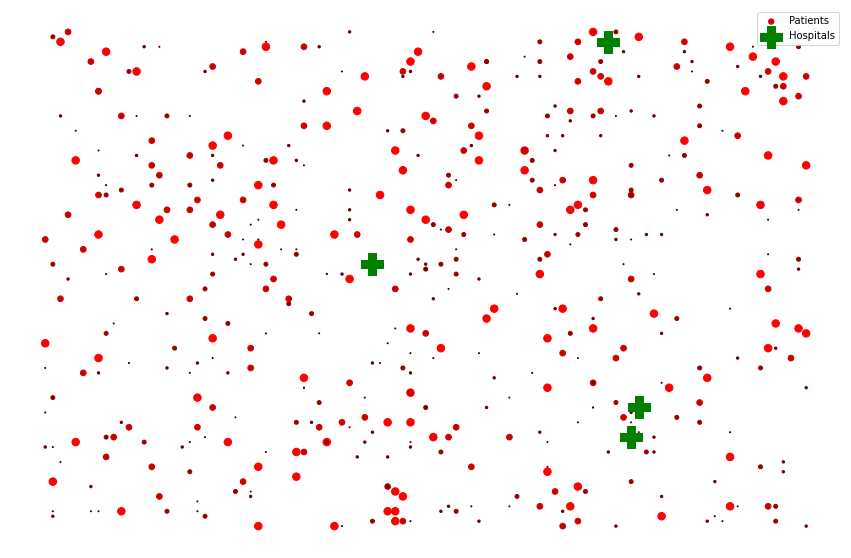

In [35]:
from itertools import cycle

shade_severity = [int(sev*255/5) for sev in patients_severity]
color_severity = ["#%02x0000" % (sev) for sev in shade_severity]
size_severity = [k**2.5 for k in patients_severity]
plt.scatter(*zip(*patients_loc), s=size_severity, c=color_severity, label="Patients", zorder=2)
plt.scatter(*zip(*hospitals_loc), s=500, c="g", marker="P", label="Hospitals", zorder=3)
colors = cycle('bgrcmk')
for i in range(n_hospitals):
  c = next(colors)
  for (x_,y_) in plot_lines[i]:
    plt.plot(x_,y_,c=c,linewidth=0.2, zorder=1)
plt.legend()
plt.axis('off')
plt.show()      